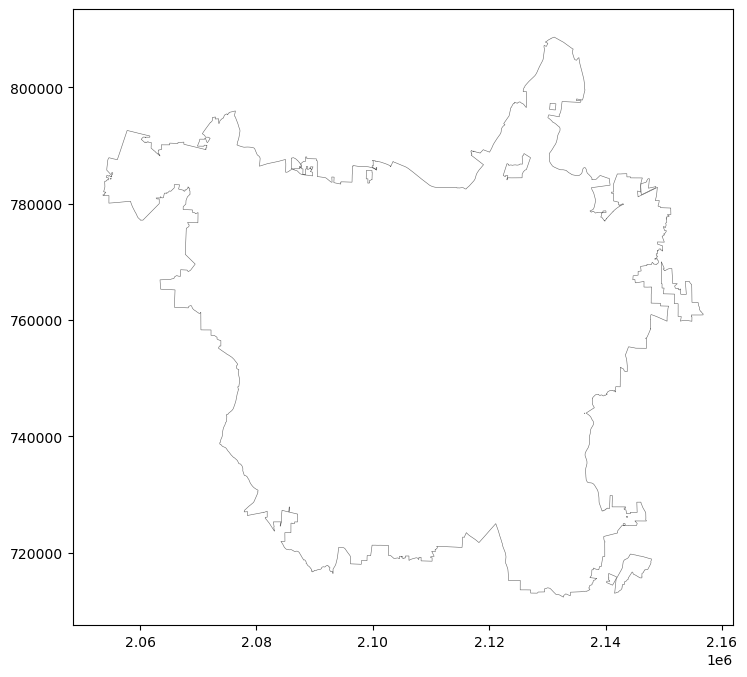

In [374]:
########################################################################################
#### Create a map of the Durham boundaries, with the sensor points and temperatures ####
########################################################################################
# Read in the packages to use
import numpy as np
import pandas as pd
import datetime
from datetime import datetime, timedelta
import os
import pathlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import earthpy as et
#import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
import geopandas as gpd
from matplotlib.offsetbox import OffsetImage, AnnotationBbox # for creating the image markers
from PIL import Image
from pathlib import Path
# load the csv with all the sensor data
# data with no gaps in timeseries nulls where there are gaps in data
os.chdir(os.path.join(Path.home() / "Documents" / "eh scholars" / "raw data" / "weeks1_to_4" / "Data_Clean"))
sensor_data_all = pd.read_csv('Weeks1_to_4_cleaned_const_timeseries.csv')

################ !!!! Note: if you want to remain in degF, change the below ################
degrees = 'F'
############################################################################################

# convert to celcius if specified 
# °C = (°F - 32) × 5/9
if degrees == 'C':
    sensor_data_all['Temperature'] = 5/9*(sensor_data_all['Temperature'] - 32)


# get the date time column into the correct format
sensor_data_all['Date_Time_Format'] = sensor_data_all.apply(lambda row: datetime.strptime(row.Date_Time_Format, '%Y-%m-%d %H:%M:%S'), axis=1)

# add in the custom hourly groups (30 mins either side of the hour)
def custom_hour(df, column_name):
    df['hour'] = df[column_name].dt.hour
    df['minute'] = df[column_name].dt.minute
    df['date'] = df['Date_Time_Format'].dt.date #get the date (add one to the date if 11:30 or after)
    df['Custom_Hour'] = df['hour'] + df['minute'].apply(lambda x: 1 if x >= 30 else 0)
    # when the hour is 24, create a date which is the next day
    df['date2'] = pd.to_datetime(df['date']) + timedelta(days=1) * df['Custom_Hour'].apply(lambda x: 1 if x == 24 else 0)
    # convert the hour to 0 if it is 24
    df['Custom_Hour'] = df['Custom_Hour'] * df['Custom_Hour'].apply(lambda x: 0 if x == 24 else 1)
    return df['Custom_Hour']

# Add custom hour
sensor_data_all['Custom_Hour'] = custom_hour(sensor_data_all, 'Date_Time_Format')
sensor_data_all['Custom_Hour'] = sensor_data_all.apply(lambda row: datetime.strptime(str(row.Custom_Hour).zfill(2), '%H').strftime("%H:%M"), axis=1)

# read in sensor info, table is exported from arcgis
sensor_info = pd.read_csv(Path.home() / "Documents" / "eh scholars" / "Sensor_Locations_ForRaleigh_062725.csv")
# just extract the info we need for now so easier to work with, and change the sensor ID field name to match the other table
sensor_info_basics = sensor_info.loc[:,['Shade','Sidewalk','SensorID','treat_25','lon_x','lat_y']].rename(columns = {'SensorID':'Sensor_ID'})

## add sensor information into the sensor data table, so it can be grouped by the diff shading/ landcover types
sensor_data_all = pd.merge(sensor_data_all, sensor_info_basics, on = 'Sensor_ID', how = 'left')

# add the mean sensor temperature into the sensor information table 
start_date = datetime.strptime('2025-06-16 00:00:00', '%Y-%m-%d %H:%M:%S')
end_date = datetime.strptime('2025-07-12 00:00:00', '%Y-%m-%d %H:%M:%S')

sensor_data_means = sensor_data_all[(sensor_data_all.Date_Time_Format > start_date) & (
    sensor_data_all.Date_Time_Format < end_date)].groupby(['Sensor_ID']).mean(numeric_only = True).reset_index()[['Sensor_ID','Temperature']].rename(
    columns = {'Temperature':'Mean_Temperature_JA'})

sensor_data_all_JA = sensor_data_all[(sensor_data_all.Date_Time_Format > start_date) & (
    sensor_data_all.Date_Time_Format < end_date)].copy()

# add the mean July August temperature to the sensor info df
sensor_info_basics = pd.merge(sensor_info_basics, sensor_data_means, on = 'Sensor_ID', how = 'left')
# remove the stolen sensors, which have no temperature data for this time
sensor_info_basics = sensor_info_basics[~np.isnan(sensor_info_basics.Mean_Temperature_JA)].reset_index(drop = True)

# get the outline of the Raleigh boundary
os.chdir(os.path.join(Path.home() / "Documents" / "eh scholars"))
zipfile = "raleigh_jurisdiction.zip"
raleigh_outline = gpd.read_file(zipfile)
p = gpd.GeoSeries(raleigh_outline.geometry)
fig, axes = plt.subplots(1,1, figsize=(10, 8))
im1 = p.plot(linewidth=0.4, ax = axes, facecolor='none',edgecolor=".4")

In [375]:
sensor_info_basics_gdf = gpd.GeoDataFrame(sensor_info_basics, geometry = gpd.points_from_xy(sensor_info_basics.lon_x, sensor_info_basics.lat_y), crs = "EPSG:4326")
raleigh_crs = p.crs
sensor_info_basics_gdf = sensor_info_basics_gdf.to_crs(raleigh_crs, epsg=None, inplace=False)

In [376]:
sensor_info_basics_gdf['x'] = sensor_info_basics_gdf.geometry.get_coordinates().x
sensor_info_basics_gdf['y'] = sensor_info_basics_gdf.geometry.get_coordinates().y

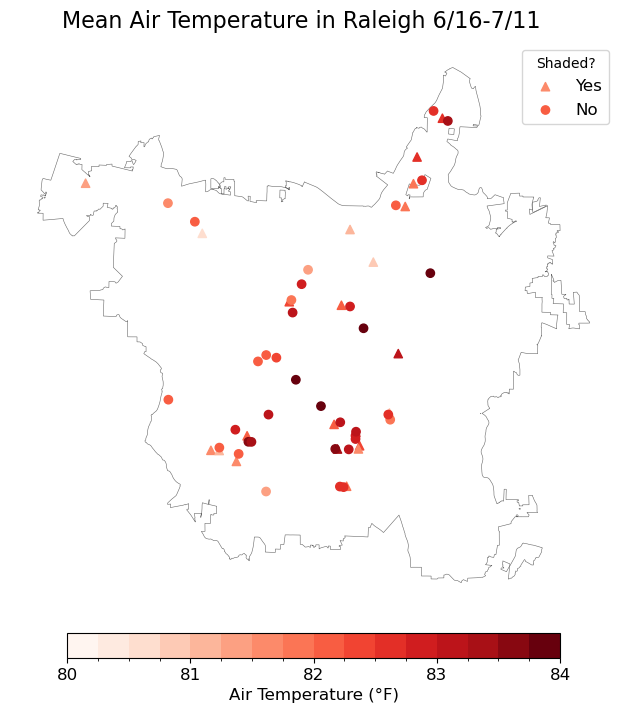

In [377]:
####################################################################
###################### DAYTIME TEMPERATURE #########################
####################################################################

fig, axes = plt.subplots(1,1, figsize=(10, 8))

fig.suptitle('Mean Air Temperature in Raleigh 6/16-7/11', fontsize=16, y = 0.92)

# mean overall values (remove week grouping)
#sensor_data_to_plot2 = sensor_data_to_plot.groupby(['Sensor_ID','Decile Group','x','y','Shade Type','Landcover Type']).mean(numeric_only = True
#                                                                                                                           ).reset_index()
sensor_data_to_plot2 = sensor_info_basics_gdf

# create the colormap
scale_min = 80
scale_max = 84
cmap = plt.cm.Reds  # define the colormap
# extract all colors from the .bwr map
cmaplist = [cmap(i) for i in range(cmap.N)]

# create the new map
colormap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

bounds = np.linspace(scale_min, scale_max, 17)
norm = mpl.colors.BoundaryNorm(bounds, colormap.N)
bounds_for_colorbar = np.linspace(scale_min, scale_max, 5)

p = gpd.GeoSeries(raleigh_outline.geometry)
#p.plot()

im1 = p.plot(linewidth=0.4, ax = axes, facecolor='none',edgecolor=".4")

#landcover_types = ['impervious', 'vegetation']
shading_types = ['Yes','No']

#for landcover_type in landcover_types:
for shading_type in shading_types:
    sensor_data_to_plot3 = sensor_data_to_plot2[(sensor_data_to_plot2['Shade'] == shading_type)]
            # &(sensor_data_to_plot2['Landcover Type'] == landcover_type)]
        # set marker style depending on shading type
    if (shading_type == 'Yes'):#&(landcover_type == 'impervious'):
            markerstyle = '^'
    elif (shading_type == 'No'):#&(landcover_type == 'impervious'): 
            markerstyle = 'o'
        #elif (shading_type == 'shaded')&(landcover_type == 'vegetation'): 
            #markerstyle = '<'
        #elif (shading_type == 'non-shaded')&(landcover_type == 'vegetation'): 
            #markerstyle = 's'
        
        # set outline color depending on landcover type - this looks strange with the cmap
        #if landcover_type == 'impervious':
        #    edgecolor = 'grey'
        #else: 
        #    edgecolor = 'green'
        
    axes.scatter(sensor_data_to_plot3.x, sensor_data_to_plot3.y, c= sensor_data_to_plot3.Mean_Temperature_JA, cmap = cmap, norm = norm, label = '{}'.format(shading_type), marker = markerstyle)

        #legend_labels.append('{} {}'.format(landcover_type, shading_type) )
        #legend_markers.append(markerstyle)


# dont want a box round the map
axes.axis("off")
axes.legend(title = 'Shaded?', fontsize = 12)

cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=colormap), ax=axes, orientation='horizontal',fraction=0.04, pad=0.04, 
                    ticks =bounds_for_colorbar)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(label= 'Air Temperature (\u00b0F)', size=12)

# uncomment this to save the plot
#plt.savefig('durham_shape_w_sensors_day.png',bbox_inches='tight',facecolor='w')#, transparent = True)

In [378]:
# adjust colorbar min and max based on these values
sensor_data_to_plot2.Mean_Temperature_JA.min(), sensor_data_to_plot2.Mean_Temperature_JA.max()

(np.float64(80.67426136363638), np.float64(83.95026455026455))

In [379]:
sensor_data_all.groupby('Shade')['Temperature'].mean()

Shade
No     82.736209
Yes    81.906624
Name: Temperature, dtype: float64

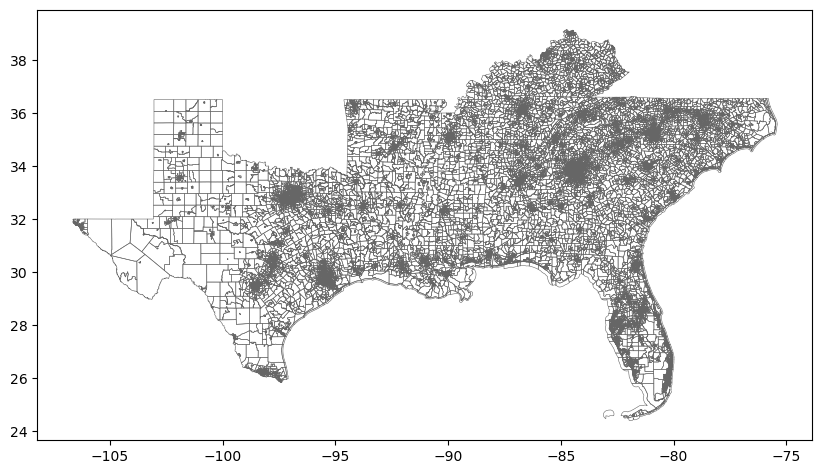

In [380]:
# demographic data
os.chdir(os.path.join(Path.home() / "Documents" / "eh scholars"))
zipfile2 = "filtered_ej_screen_2023.zip"
ej_outline = gpd.read_file(zipfile2)
p = gpd.GeoSeries(ej_outline.geometry)
fig, axes = plt.subplots(1,1, figsize=(10, 8))
im2 = p.plot(linewidth=0.4, ax = axes, facecolor='none',edgecolor=".4")

In [381]:
# filter for Wake County
nc_ej_outline = ej_outline[ej_outline['STATE_NAME'] == 'North Carolina']
raleigh_ej_outline = nc_ej_outline[nc_ej_outline['CNTY_NAME'] == 'Wake']

# list all variables to determine syntax for labels, compare with EJ screen codebook
list(raleigh_ej_outline.columns.values)

['OBJECTID',
 'ID',
 'STATE_NAME',
 'ST_ABBREV',
 'CNTY_NAME',
 'REGION',
 'ACSTOTPOP',
 'ACSIPOVBAS',
 'ACSEDUCBAS',
 'ACSTOTHH',
 'ACSTOTHU',
 'ACSUNEMPBA',
 'DEMOGIDX_2',
 'DEMOGIDX_5',
 'PEOPCOLOR',
 'PEOPCOLORP',
 'LOWINCOME',
 'LOWINCPCT',
 'UNEMPLOYED',
 'UNEMPPCT',
 'LINGISO',
 'LINGISOPCT',
 'LESSHS',
 'LESSHSPCT',
 'UNDER5',
 'UNDER5PCT',
 'OVER64',
 'OVER64PCT',
 'LIFEEXPPCT',
 'PM25',
 'OZONE',
 'DSLPM',
 'CANCER',
 'RESP',
 'RSEI_AIR',
 'PTRAF',
 'PRE1960',
 'PRE1960PCT',
 'PNPL',
 'PRMP',
 'PTSDF',
 'UST',
 'PWDIS',
 'D2_PM25',
 'D5_PM25',
 'D2_OZONE',
 'D5_OZONE',
 'D2_DSLPM',
 'D5_DSLPM',
 'D2_CANCER',
 'D5_CANCER',
 'D2_RESP',
 'D5_RESP',
 'D2_RSEI_AI',
 'D5_RSEI_AI',
 'D2_PTRAF',
 'D5_PTRAF',
 'D2_LDPNT',
 'D5_LDPNT',
 'D2_PNPL',
 'D5_PNPL',
 'D2_PRMP',
 'D5_PRMP',
 'D2_PTSDF',
 'D5_PTSDF',
 'D2_UST',
 'D5_UST',
 'D2_PWDIS',
 'D5_PWDIS',
 'P_DEMOGIDX',
 'P_DEMOGI_1',
 'P_PEOPCOLO',
 'P_LOWINCPC',
 'P_UNEMPPCT',
 'P_LINGISOP',
 'P_LESSHSPC',
 'P_UNDER5PC',
 'P_OVER64PC

In [382]:
sensor_info_basics_gdf2 = gpd.GeoDataFrame(sensor_info_basics, geometry = gpd.points_from_xy(sensor_info_basics.lon_x, sensor_info_basics.lat_y), crs = "EPSG:4269")
raleigh_ej_crs = p.crs
sensor_info_basics_gdf2 = sensor_info_basics_gdf2.to_crs(raleigh_ej_crs, epsg=None, inplace=False)

In [383]:
sensor_info_basics_gdf2['x'] = sensor_info_basics_gdf2.geometry.get_coordinates().x
sensor_info_basics_gdf2['y'] = sensor_info_basics_gdf2.geometry.get_coordinates().y

In [384]:
raleigh_outline_test = raleigh_outline
raleigh_ej_outline_test = raleigh_ej_outline
if raleigh_ej_outline_test.crs != raleigh_outline_test.crs:
    raleigh_outline_test = raleigh_outline_test.to_crs(raleigh_ej_outline_test.crs)

# Clip the states GeoDataFrame to specifically Raleigh, not all of Wake County
clipped_states = gpd.clip(raleigh_ej_outline_test, raleigh_outline_test)

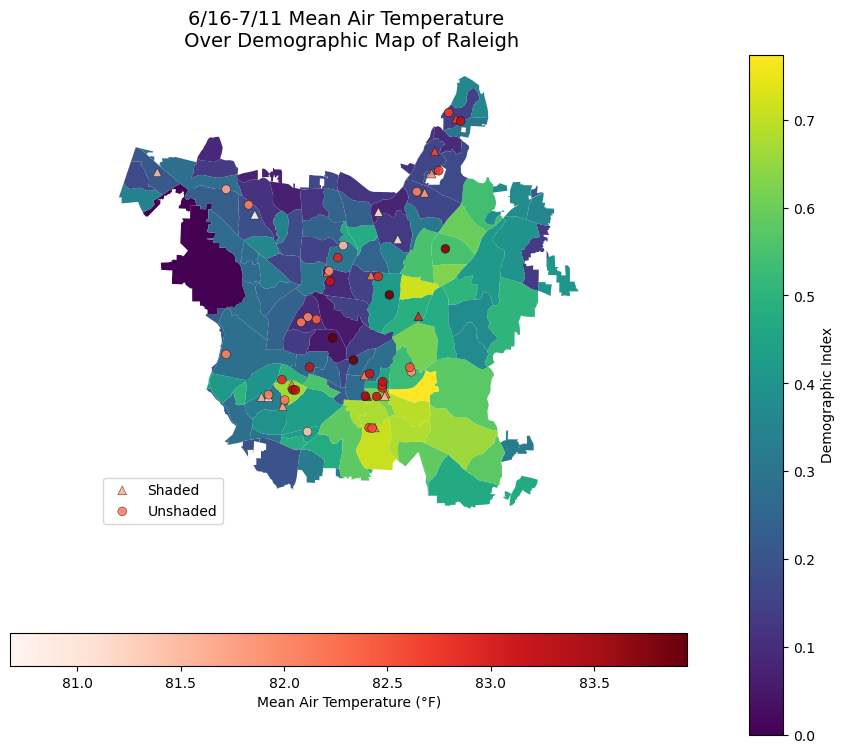

In [385]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.cm import ScalarMappable
import matplotlib.colors as colors

fig, ax = plt.subplots(figsize=(10, 10))

# Plot base
ej_plot = clipped_states.plot(column="DEMOGIDX_2",cmap="viridis",ax=ax,legend=False)

norm1 = colors.Normalize(
    vmin=raleigh_ej_outline["DEMOGIDX_2"].min(),
    vmax=raleigh_ej_outline["DEMOGIDX_2"].max())

sm1 = ScalarMappable(cmap="viridis", norm=norm1)
sm1._A = []

# Split sensors by shading
shaded = sensor_info_basics_gdf2[sensor_info_basics_gdf2["Shade"] == "Yes"]
unshaded = sensor_info_basics_gdf2[sensor_info_basics_gdf2["Shade"] == "No"]

norm_temp = colors.Normalize(
    vmin=sensor_info_basics_gdf2["Mean_Temperature_JA"].min(),
    vmax=sensor_info_basics_gdf2["Mean_Temperature_JA"].max()
)
cmap_temp = plt.cm.Reds

# Plot shaded sensors
shaded.plot(ax=ax,column="Mean_Temperature_JA",cmap=cmap_temp,markersize=40,marker='^',norm=norm_temp,edgecolor="black",linewidth=0.3,alpha=0.9,label="Shaded")

# Plot unshaded sensors
unshaded.plot(ax=ax,column="Mean_Temperature_JA",cmap=cmap_temp,markersize=40,marker='o',norm=norm_temp,edgecolor="black",linewidth=0.3,alpha=0.9,label="Unshaded")

# Add legend for shaded/unshaded markers
import matplotlib.lines as mlines

legend_handles = [
    mlines.Line2D([], [], color='red', marker='^', linestyle='None', label='Shaded', markeredgecolor='black'),
    mlines.Line2D([], [], color='red', marker='o', linestyle='None', label='Unshaded', markeredgecolor='black')]

#for landcover_type in landcover_types:
norm2 = colors.Normalize(
    vmin=sensor_info_basics_gdf2["Mean_Temperature_JA"].min(),
    vmax=sensor_info_basics_gdf2["Mean_Temperature_JA"].max())

sm2 = ScalarMappable(cmap="Reds", norm=norm2)
sm2._A = []

fig.subplots_adjust(bottom=0.2)

cbar1 = fig.colorbar(sm1, ax=ax, orientation="vertical", pad=0.08, fraction=0.046)
cbar1.set_label("Demographic Index")

cbar2 = fig.colorbar(sm2, ax=ax, orientation="horizontal")
cbar2.set_label("Mean Air Temperature (°F)")

ax.set_title("6/16-7/11 Mean Air Temperature \n Over Demographic Map of Raleigh", fontsize=14)
plt.legend(loc = 'lower left')
plt.axis("off")
plt.show()